#Quora Question Pairs
##Can you identify question pairs that have the same intent?

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

## I want to compare several approaches to meashure sentences similarity in this paper:
  1. Words embedding and cosine similarity;
  2. Sentence encoder (BiLSTM) + simple classifier (FeedForward NN);
  3. Transformers;  

In [2]:
import spacy
from spacy.tokens import Doc
from spacy.vocab import Vocab
import numpy as np
from scipy import spatial
import pandas as pd
import array
from sklearn import metrics
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import torch.onnx
import onnx

In [1]:
!pip install onnx

     |████████████████████████████████| 12.8 MB 4.1 MB/s 


In [ ]:
!python -m spacy download en_core_web_md

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
     |████████████████████████████████| 96.4 MB 1.7 MB/s 
ERROR: Operation cancelled by user
^C


## Prepare data


In [ ]:
nlp = spacy.load("en_core_web_md")

In [3]:
df = pd.read_csv("train.csv", engine='python', error_bad_lines=False, index_col='id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data = df[['question1', 'question2']]

In [6]:
data.head()

,question1,question2
id,,
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [5]:
data_list = list(zip(list(data['question1']), list(data['question2'])))

In [8]:
data_list[0]

('What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?')

## First approach 
Make embeddings for each word in sentence, then calculate mean value for sentence. Finally calculate cosine distance between two vectors.

In [ ]:
# delete stop words, lowercase and tokenize
def tokenize(sentence: str, nlp):
  stop_words = nlp.Defaults.stop_words
  tokens = sentence.split()
  sentence_without_sw = ' '.join([token.lower() for token in tokens if token not in stop_words])
  tokens_without_sw = nlp(sentence_without_sw)
  return tokens_without_sw

In [ ]:
def cosine_similarity(sentence1: str, sentence2: str, nlp) -> int:
  embedding1 = tokenize(sentence1, nlp).tensor.mean(axis=0)
  embedding2 = tokenize(sentence2, nlp).tensor.mean(axis=0)
  return spatial.distance.cosine(embedding1, embedding2)

In [ ]:
def predict(data_list, nlp):
  result = []
  for tup in data_list[:10000]:
    result.append(cosine_similarity(tup[0], tup[1], nlp))
  result = np.array(result)
  result /= max(result)

  return (result > 0.5).astype(int)

In [ ]:
predicted_list = predict(data_list, nlp)

In [ ]:
labels = np.array(df['is_duplicate'][:10000])

In [ ]:
metrics.accuracy_score(predicted_list, labels)

0.5445

As we can see, it is not good approach for this task. Accuracy 0.54 is too small.

Now use spacy method.

In [ ]:
sentence = 'My name is definetly Vova'
sentence2 = 'My name is Vova'
toks1 = nlp(sentence)
toks2 = nlp(sentence2)
toks1.similarity(toks2)

0.9631748208608146

In [ ]:
def predict_spacy(data_list, nlp):
  result = []
  for tup in data_list[:10000]:
    result.append(nlp(tup[0]).similarity(nlp(tup[1])))
  result = np.array(result)
  return (result < 0.5).astype(int)

In [ ]:
predicted_list_spacy = predict_spacy(data_list, nlp)

In [ ]:
metrics.accuracy_score(predicted_list_spacy, labels)

0.6274

Results with spaCy approach a bit better. 

## Second approach: LSTM
Train our own model for encoding, then use simple classifier to check similarity.

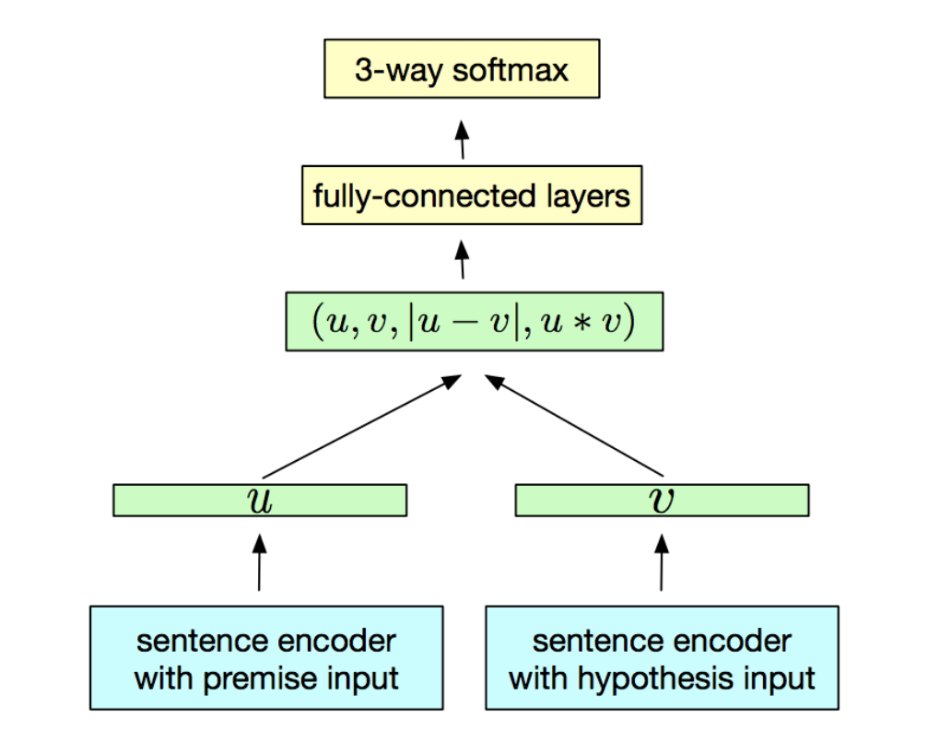

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Build own encoder
We vectorize each sentence in dataset with gensim W2V. Then training encoder model. Now in evaluation mode we can vectorise sentences with this model, by getting output from N-1 model layer.


In [7]:
NUM_EPOCH = 80
NUM_LAYERS = 3
NUM_CLASSES = 6

BATCH_SIZE = 256
#INPUT_SIZE = 96
INPUT_SIZE = 300
HIDDEN_SIZE = 128
SEQUENCE_LEN = 25

LEARNING_RATE = 0.001

In [8]:
# create embeddings with spaCy
def create_embeddings(data, nlp, column_number, number_of_examples):
  embeddings_list = []
  idx = 0
  for sentence in list(data.iloc[:, column_number])[:number_of_examples]:
    if not isinstance(sentence, str):
      work_sentence = str(sentence)[:SEQUENCE_LEN]
    else:
      work_sentence = sentence[:SEQUENCE_LEN]
    if idx != 0 and idx % 2000 == 0:
      print(idx)
    #try:
    spacy_embedded_sentence = nlp(work_sentence)
    #except Exception:
    #  print(Exception)
    #  continue
    tensor_width = spacy_embedded_sentence.tensor.shape[0]
    #if tensor_width < SEQUENCE_LEN:
    embedded_sentence = torch.zeros(SEQUENCE_LEN, INPUT_SIZE)
    embedded_sentence[:tensor_width, :] = torch.from_numpy(spacy_embedded_sentence.tensor)
    # else:
    #   embedded_sentence = torch.zeros(SEQUENCE_LEN, INPUT_SIZE)
    #   embedded_sentence = torch.from_numpy(spacy_embedded_sentence.tensor[:SEQUENCE_LEN, :])
    embeddings_list.append(torch.unsqueeze(embedded_sentence, 0))
    idx += 1
  return torch.cat(embeddings_list, dim=0)

In [156]:
# download gensim w2v 
model_w2v = api.load("word2vec-google-news-300") 

In [10]:
#create embeddings with gensim
def create_embeddings_gensim(data, column_number, number_of_examples):
  embedded_sentences = []
  for i, sentence in enumerate(list(data.iloc[:, column_number])[:number_of_examples]):
    if i % 2000 == 0:
      print(i)
    temp_sentence = []
    if not isinstance(sentence, str):
      temp_sentence = str(sentence)[:SEQUENCE_LEN]
      if len(temp_sentence) < SEQUENCE_LEN:
        temp_sentence += ' ' * (SEQUENCE_LEN - len(temp_sentence))
    else:
      temp_sentence = sentence[:SEQUENCE_LEN]
      if len(temp_sentence) < SEQUENCE_LEN:
        temp_sentence += ' ' * (SEQUENCE_LEN - len(temp_sentence))
    embedded_sentence = []
    for word in temp_sentence:
      try:
        embedding = model_w2v.get_vector(word)
      except:
        embedding = np.zeros(300)
      embedded_sentence.append(torch.unsqueeze(torch.tensor(embedding, dtype=torch.float), 0))
    embedded_sentences.append(torch.unsqueeze(torch.cat(embedded_sentence, dim=0), 0))
  return torch.cat(embedded_sentences, dim=0)

In [11]:
# here is bidirectional LSTM
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
      super(LSTM, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.dropout = 0.3
      self.LSTM = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = self.dropout)
      self.fc_1 = nn.Linear(hidden_size * 2, 128)
      self.fc_2 = nn.Linear(128, 128)
      self.fc = nn.Linear(128, num_classes)
      # x needs to be: (batch_size, seq, input_size)
  
  def forward(self, x):
    #init hidden and cell states for lstm
    #(num_layers, batch_size, hidden_size)
    # multiply x2 because here is BIDIRECTIONAL LSTM
    h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 

    x = x.to(device)
    out, _ = self.LSTM(x, (h0, c0)) 
    #out -> (batch_size, seq_length, hidden_size)
    #Decode the hidden state of the last time step
    out = out[:, -1, :]
    out = self.fc_1(out)
    out = self.fc_2(out)
    out = self.fc(out)
    # out: (n, num_classes)
    return out

  def backward(self, out, labels, criterion, optimizer):
    optimizer.zero_grad()
    labels = labels.to(device)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
def train_model(model, num_epochs, data_loader, criterion, optimizer):
  total_loss = 0
  loss_list = []
  total_steps = num_epochs * len(data_loader)
  for epoch in range(num_epochs):
    for i, (x, labels) in enumerate(data_loader):
      out = model.forward(x)
      loss = model.backward(out, labels, criterion, optimizer)
      total_loss += loss.item()
      loss_list.append(loss.item())
      if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{epoch}/{total_steps}], Loss: {loss.item():.4f}')
  return loss_list, total_loss

### Prepare dataset
I use dataset for sentiment analysis.

In [13]:
#prepare train dataset
data_encoder = pd.read_csv('train_encoder.csv', index_col='id')
data_encoder.dropna()

,comment_text,toxicity
id,,
0,fuck you you self righteous creep,3
1,stop stop the goddam vandalism or there ll be...,2
2,i agree rt does have a few shortcomings but i...,0
3,if you would like verfiability here is the lin...,0
4,do you think there s consensus for me to be on...,0
...,...,...
34642,huy i am kyle robbins i think albert pujols is...,4
34643,unlike the ancient greeks the idiot who bloc...,4
34644,no it isn t so if you wish to delete my accou...,1


In [ ]:
features = create_embeddings_gensim(data_encoder, 0, 25000)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000


In [ ]:
features[0].shape

torch.Size([25, 300])

In [ ]:
# prepare dataloader
labels = torch.tensor(list(data_encoder['toxicity']), dtype=torch.long)
train_tensor_dataset = TensorDataset(features, labels[:25000])
train_dataloader = torch.utils.data.DataLoader(dataset=train_tensor_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

In [ ]:
#train 
model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

### Train encoder model

In [ ]:
loss_list, _ = train_model(model, NUM_EPOCH, train_dataloader, criterion, optimizer)

Epoch [1/80], Step [0/7840], Loss: 1.4750
Epoch [1/80], Step [0/7840], Loss: 1.4892
Epoch [1/80], Step [0/7840], Loss: 1.4505
Epoch [1/80], Step [0/7840], Loss: 1.4005
Epoch [1/80], Step [0/7840], Loss: 1.4131
Epoch [1/80], Step [0/7840], Loss: 1.3178
Epoch [1/80], Step [0/7840], Loss: 1.3785
Epoch [1/80], Step [0/7840], Loss: 1.3571
Epoch [1/80], Step [0/7840], Loss: 1.3542
Epoch [2/80], Step [1/7840], Loss: 1.2900
Epoch [2/80], Step [1/7840], Loss: 1.3703
Epoch [2/80], Step [1/7840], Loss: 1.2739
Epoch [2/80], Step [1/7840], Loss: 1.2951
Epoch [2/80], Step [1/7840], Loss: 1.3515
Epoch [2/80], Step [1/7840], Loss: 1.3207
Epoch [2/80], Step [1/7840], Loss: 1.3887
Epoch [2/80], Step [1/7840], Loss: 1.2386
Epoch [2/80], Step [1/7840], Loss: 1.2702
Epoch [3/80], Step [2/7840], Loss: 1.2757
Epoch [3/80], Step [2/7840], Loss: 1.3516
Epoch [3/80], Step [2/7840], Loss: 1.2166
Epoch [3/80], Step [2/7840], Loss: 1.2058
Epoch [3/80], Step [2/7840], Loss: 1.2979
Epoch [3/80], Step [2/7840], Loss:

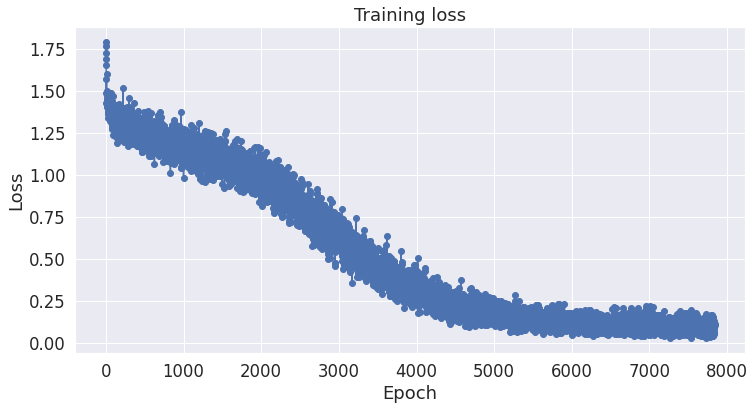

In [ ]:
#Use plot styling from seaborn.
sns.set(style='darkgrid')

#Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Plot the learning curve.
plt.plot(loss_list, 'b-o')

#Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# prepare test dataloader
labels_test = torch.tensor(list(data_encoder_test['toxicity']), dtype=torch.long)
test_tensor_dataset = TensorDataset(features_test, labels_test)
test_dataloader = torch.utils.data.DataLoader(dataset=test_tensor_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    predicted_list = []
    for x, labels in test_dataloader:
        x = x.to(device)
        labels = labels.to(device)
        outputs = model(x)
        #max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.extend(predicted.tolist())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    print(metrics.accuracy_score(predicted_list, labels_test[:9000].tolist()))

0.473


In [ ]:
# save model as pth and onnx
torch.save(model.state_dict(), 'model_encoder.pth')
dummy_input = Variable(torch.randn(1, 25, 300)).cuda()
torch.onnx.export(model, dummy_input, "model_encoder.onnx")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


In [17]:
# download model
model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
model.load_state_dict(torch.load('/content/model_encoder.pth'))
model.eval()

LSTM(
  (LSTM): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

### Create vectorised dataset for classification (text similarity) 

In [28]:
# this code extract encoded vector from n-th layer of nn
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_encoded_sentences(dataloader, model):
  model.fc_2.register_forward_hook(get_activation('fc_2'))
  vectors = []
  #sentence here is vector of embeddings
  for i, (sentence_batch, label) in enumerate(dataloader):
    if i % 1000 == 0:
      print('Iteration: {}'.format(i))
    for sentence in sentence_batch:
      #vectors.append(tensor) 
      output = model(torch.unsqueeze(sentence, 0))
      vectors.append(torch.unsqueeze(activation['fc_2'], 0))
  return torch.cat(vectors, dim=0)

In [ ]:
encoded_vectors1 = get_encoded_sentences(test_dataloader, model)

In [19]:
data.iloc[:100, :]

,question1,question2
id,,
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
...,...,...
95,How does 3D printing work?,How do 3D printing work?
96,What was it like to attend Caltech with Jeremy...,Who are some notable folks who attended Caltech?
97,Why did harry become a horcrux?,What is a Horcrux?


In [19]:
#encoded dataset: V, U, V*U, |V-U|
def create_encoded_dataset(data, model):
  #create features
  features1 = create_embeddings_gensim(data, 0, len(data))
  features2 = create_embeddings_gensim(data, 1, len(data))
  #create dataloaders
  tensor_dataset1 = TensorDataset(features1, torch.zeros(len(features1)))
  dataloader1 = torch.utils.data.DataLoader(dataset=tensor_dataset1, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=False)
  tensor_dataset2 = TensorDataset(features2, torch.zeros(len(features2)))
  dataloader2 = torch.utils.data.DataLoader(dataset=tensor_dataset2, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=False)
  print("Dataloaders completed. Encoding started...")
  encoded_vector1 = get_encoded_sentences(dataloader1, model)
  encoded_vector2 = get_encoded_sentences(dataloader2, model)
  print("Encoding completed!")
  vector_multiplicated = encoded_vector1 * encoded_vector2
  vector_difference = torch.abs(encoded_vector1 - encoded_vector2)
  return encoded_vector1, encoded_vector2, vector_multiplicated, vector_difference

In [87]:
encoded_vector1, encoded_vector2, vector_multiplicated, vector_difference = create_encoded_dataset(data.iloc[:50000, :], model)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
Dataloaders completed. Encoding started...
Iteration: 0
Iteration: 0
Encoding completed!


In [124]:
encoded_vector1.shape

torch.Size([50000, 1, 128])

In [146]:
encoded_dataset = torch.cat([encoded_vector1, encoded_vector2, vector_multiplicated, vector_difference], 1)

### Create simple classifier model

In [148]:
class Classifier(nn.Module):
  def __init__(self, input_size):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.dropout = nn.Dropout(0.1)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)

  def forward(self, x):
    x = x.to(device)
    out = self.fc1(x)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

  def backward(self, out, labels, criterion, optimizer):
    optimizer.zero_grad()
    labels = labels.to(device)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss
  

In [149]:
# train classiffier function
def train_classifier(model, dataloader, num_epochs, criterion, optimizer):
  loss_list = []
  total_steps = num_epochs * len(dataloader)
  for i_epoch, epoch in enumerate(range(num_epochs)):
    for i, (values, labels) in enumerate(dataloader):
      out = model.forward(values)
      loss = model.backward(out, labels, criterion, optimizer)
      loss_list.append(loss.item())
    print('Epoch: {}/{}, Step: {}/{}, Loss: {}'.format(i_epoch, num_epochs, i*(epoch+1), total_steps, loss_list[-1]))
  return loss_list
  
# get predictions with classifier
def classify(model, dataloader):
  model.to(device)
  model.eval()
  predicted_list = []
  with torch.no_grad():
    for i, (value, label) in enumerate(dataloader):
      # max returns (value ,index)
      value.to(device)
      label.to(device)
      outputs = model(value)
      _, predicted = torch.max(outputs.data, 1)
      predicted_list.extend(predicted.tolist())
  return predicted_list

In [150]:
# flutten input vectors 
fluttened_encoded_values = torch.flatten(encoded_dataset, start_dim=1)
print(fluttened_encoded_values.shape)
input_size = int(fluttened_encoded_values.shape[1])
print(input_size)

torch.Size([50000, 512])
512


In [151]:
# prepare learning
lr = 10**-4
batch_classifier = 512
train_len = int(0.8 * len(fluttened_encoded_values))
num_epoch = 100

labels_classifier = torch.tensor(list(df['is_duplicate'][:len(fluttened_encoded_values)]), dtype=torch.long)
train_tensor_dataset_cls = TensorDataset(fluttened_encoded_values[:train_len], labels_classifier[:train_len])
test_tensor_dataset_cls = TensorDataset(fluttened_encoded_values[train_len:], labels_classifier[train_len:])

train_dataloader_cls = torch.utils.data.DataLoader(dataset=train_tensor_dataset_cls, 
                                           batch_size=batch_classifier, 
                                           shuffle=True)
test_dataloader_cls = torch.utils.data.DataLoader(dataset=test_tensor_dataset_cls, 
                                           batch_size=batch_classifier, 
                                           shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

In [152]:
# create classifier
classifier = Classifier(input_size).to(device)

In [153]:
loss_list_classifier = train_classifier(classifier, train_dataloader_cls, num_epoch, criterion, optimizer)

Epoch: 0/100, Step: 78/7900, Loss: 0.7230342030525208
Epoch: 1/100, Step: 156/7900, Loss: 0.7634301781654358
Epoch: 2/100, Step: 234/7900, Loss: 0.6942362189292908
Epoch: 3/100, Step: 312/7900, Loss: 0.7127643823623657
Epoch: 4/100, Step: 390/7900, Loss: 0.728026807308197
Epoch: 5/100, Step: 468/7900, Loss: 0.7054671049118042
Epoch: 6/100, Step: 546/7900, Loss: 0.702765703201294
Epoch: 7/100, Step: 624/7900, Loss: 0.7327144742012024
Epoch: 8/100, Step: 702/7900, Loss: 0.7352213859558105
Epoch: 9/100, Step: 780/7900, Loss: 0.7313041687011719
Epoch: 10/100, Step: 858/7900, Loss: 0.7331843376159668
Epoch: 11/100, Step: 936/7900, Loss: 0.7041925191879272
Epoch: 12/100, Step: 1014/7900, Loss: 0.7041435837745667
Epoch: 13/100, Step: 1092/7900, Loss: 0.7364386916160583
Epoch: 14/100, Step: 1170/7900, Loss: 0.7408301830291748
Epoch: 15/100, Step: 1248/7900, Loss: 0.7055040597915649
Epoch: 16/100, Step: 1326/7900, Loss: 0.7488868832588196
Epoch: 17/100, Step: 1404/7900, Loss: 0.7229365110397339

In [154]:
predicted = classify(classifier, test_dataloader_cls)

In [155]:
metrics.accuracy_score(predicted, labels_classifier[train_len:].tolist())

0.3758

Result - 0.38. It is very bad result. Algorithm is similar to constant one.

This approach doesn't work in this particular case. I think it's my fault, encoder model needs more data, and it needs another data.